In [25]:
import pandas as pd
import numpy
import sklearn
import seaborn as sns
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

## fonctions utile :

In [42]:


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=True)
            plt.savefig("High resoltion.png",dpi=300)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    plt.savefig("Eboulis valeur porpres.png",dpi=300)
    

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [27]:
data = pd.read_csv("notes.csv")
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


## Analyse en composante principale :

In [29]:
columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
data_pca = data[columns]
data_pca

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


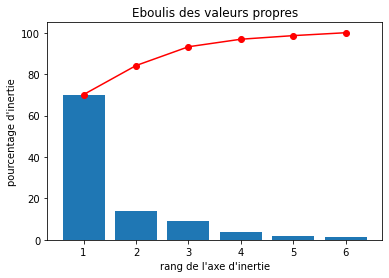

<Figure size 432x288 with 0 Axes>

In [43]:
# nombre de composante 
n_comp = 6

# préparation des données pour l'acp
data_pca = data_pca.fillna(data_pca.mean())
X = data_pca.values
names = data['is_genuine']
features = data_pca.columns

#Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(data_pca)

# Éboulis des valeurs propre
display_scree_plot(pca)

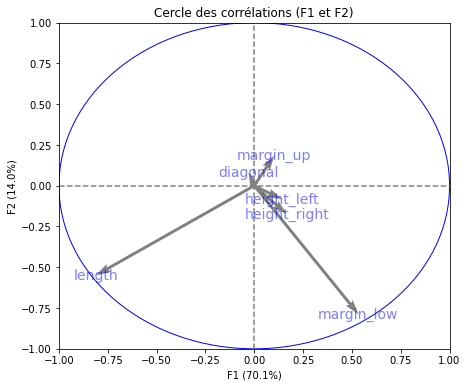

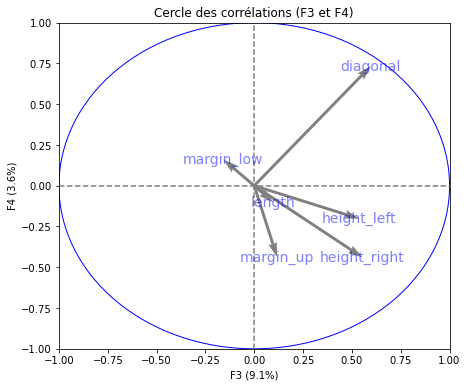

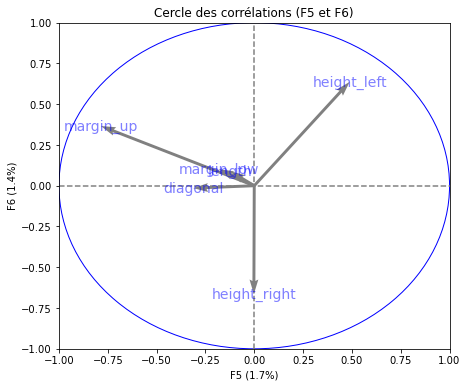

In [31]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

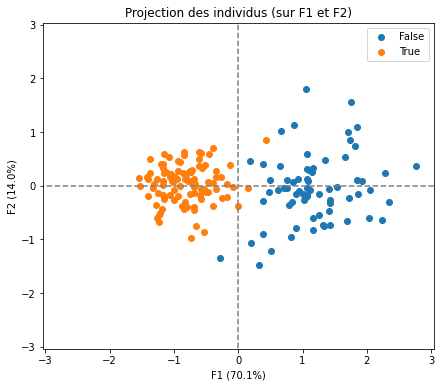

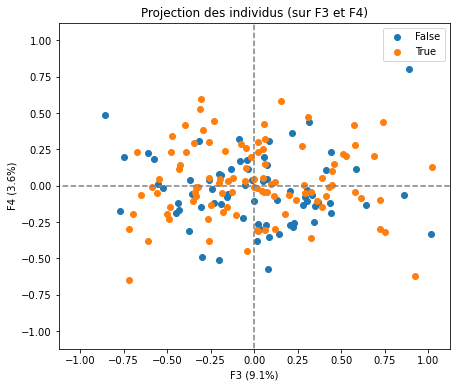

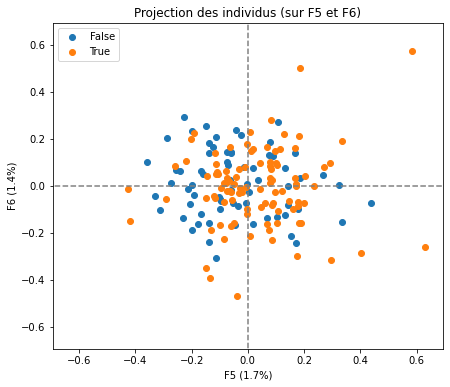

In [32]:
# Projection des individus
X_projected = pca.transform(data_pca)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)],illustrative_var=data['is_genuine'])

In [33]:
# Contribution des individus dans l'inertie totale
dist = np.sum(data_pca**2,axis=1)
print("Contribution des individus dans l'inertie totale :\n",dist)
# Qualité de la représentation des individus
cos2 = X_projected**2
for i in range(6):
    cos2[:,i] = cos2[:,i]/dist
print(pd.DataFrame({'id':data_pca.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

Contribution des individus dans l'inertie totale :
 0      64288.1896
1      63845.2076
2      64045.0241
3      63964.2751
4      64043.1120
          ...    
165    63930.5899
166    64087.8365
167    63739.9095
168    63672.8000
169    63546.2902
Length: 170, dtype: float64
      id        COS2_1        COS2_2
0      0  1.419686e-10  2.189010e-06
1      1  1.601697e-05  7.538654e-08
2      2  2.398916e-05  4.507689e-06
3      3  3.138623e-05  4.278475e-07
4      4  8.596876e-06  1.472150e-05
..   ...           ...           ...
165  165  1.970133e-05  9.088036e-08
166  166  4.339619e-05  4.340008e-06
167  167  4.711415e-05  1.136758e-05
168  168  6.660298e-06  2.128798e-06
169  169  5.390998e-05  1.606969e-07

[170 rows x 3 columns]


## Classification kmeans :

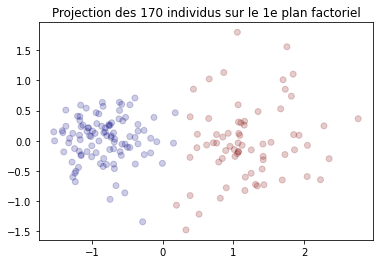

In [34]:
# Nombre de cluster 
n_clust = 2

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(data_pca)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(data_pca)
X_projected = pca.transform(data_pca)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

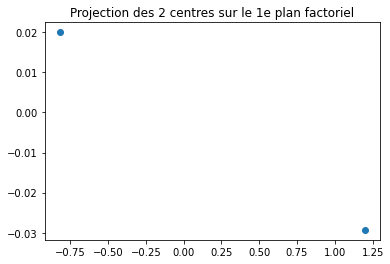

In [35]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

En projetant la partition sur le premier plan factoriel on se rend compte que les billets qui sont considéré comme vrai se situent aux alentours de -0.75 en abscisse et 0.02 en ordonnée. contrairement au billet considéré comme faux qui sont proches de 1.20 en abscisse et -0.03 en ordonnée

### Matrice de confusion :

In [37]:
metrics.confusion_matrix(data['is_genuine'], clusters)

array([[ 2, 68],
       [99,  1]])

##### La matrice de confusion nous montre que nous avons 2 faux négatifs et 1 faux positifs il y a donc trois erreurs ce qui représente 1.76% d'erreurs

## Régréssion logistique :

In [38]:
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [39]:
reg_log2 = smf.glm('is_genuine~margin_low+length+height_left+height_right',
                   data=data, family=sm.families.Binomial()).fit()

print(reg_log2.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                  170
Model:                                                   GLM   Df Residuals:                      165
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                    nan
Date:                                       Tue, 13 Jul 2021   Deviance:                          nan
Time:                                               00:11:08   Pearson chi2:                     10.2
No. Iterations:                                          100                                         
Covariance Type:                                   nonrobust                      

/Users/emmanuelmoudoute-bell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/emmanuelmoudoute-bell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/Users/emmanuelmoudoute-bell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/Users/emmanuelmoudoute-bell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:945: RuntimeWarning: invalid value encountered in add
  return (special.gammaln(n + 1) - special.gammaln(y + 1) -


In [40]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [41]:
# Valeurs caractéristiques et valeur cible 
x = data[['margin_low', 'length', 'height_left', 'height_right']]
y = data['is_genuine']

# fractionner dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

#instanciation du modèle
modele_regLog = linear_model.LogisticRegression(random_state = 0,
solver = 'liblinear', multi_class = 'auto')
#training
modele_regLog.fit(x_train,y_train)
#précision du modèle
precision = modele_regLog.score(x_test,y_test)
print(precision*100)

100.0


In [ ]:
metrics.confusion_matrix(y_te, xtrain)

In [137]:
csv = pd.read_csv('example.csv')
csv

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [152]:
prob = modele_regLog.predict_proba(csv[['margin_low', 'length', 'height_left', 'height_right']])
print(modele_regLog.classes_)
result = pd.DataFrame(columns = ['Id' , 'Statut'])
for i in range(len(csv)):
    if prob[i][0] >= 0.5:
        result = result.append({'Id' : csv['id'][i] , 'Statut' : False} , ignore_index=True)
    if prob[i][1] > 0.5:
        result = result.append({'Id' : csv['id'][i] , 'Statut' : True} , ignore_index=True)  

result

[False  True]


,Id,Statut
0,A_1,False
1,A_2,False
2,A_3,False
3,A_4,True
4,A_5,True


In [50]:
def mark_detector (mark_csv) :
    # lecture du fichier
    mark_csv = pd.read_csv(mark_csv)
    prob = modele_regLog.predict_proba(mark_csv[['margin_low', 'length', 'height_left', 'height_right']])
    result = pd.DataFrame(columns = ['Id' , 'Statut'])
    for i in range(len(mark_csv)):
        if prob[i][0] >= 0.5:
            result = result.append({'Id' : mark_csv['id'][i] , 'Statut' : False, 'proba' :  prob[i][0]} , ignore_index=True)
        if prob[i][1] > 0.5:
            result = result.append({'Id' : mark_csv['id'][i] , 'Statut' : True, 'proba' :  prob[i][1]} , ignore_index=True)  

    return result
    
    
    

In [51]:
test_function = mark_detector('test_P6.csv')
test_function

,Id,Statut,proba
0,B_1,True,0.954222
1,B_2,False,0.939228
2,B_3,True,0.993545
3,B_4,False,0.992735
4,B_5,False,0.927938
